In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from PIL import Image
from dataset import *
from save_load import *
from NN_library.AutoUnet.AutoUnet_uniform import *
from NN_library.AutoUnet.train_AutoUnet import *
from NN_library.VAE.VAE import *
from torch.nn.functional import gumbel_softmax, pad, avg_pool2d
%load_ext autoreload
%autoreload 2

Using device: cuda
Using device: cuda


In [2]:
data = dataset_uniform()
loaders = get_loaders(data, 1)
args = {'lr' : 0.001, 'epochs' : 20, 'dev' : dev}

In [3]:
name_unet = 'NN_library/AutoUnet/AutoUnet_uniform'
unet = AutoUNet()
unet = load_network(unet, name_unet, args)
unet = unet.to(dev)
for p in unet.parameters():
    p.requires_grad_ = False
unet.eval()

AutoUNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  (upconv1): ConvTranspose2d

In [4]:
geometry, damage, imp_shrinkage, _, _ = data.__getitem__(1)

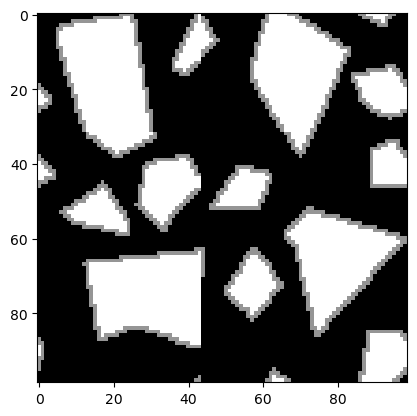

In [10]:
plt.imshow(geometry[0], cmap='Greys', vmin=0, vmax=1)

In [9]:
def add_interface(geometry_bw):
    geometry_ud = geometry_bw[:,1:] - geometry_bw[:,:-1]
    geometry_diff = torch.zeros_like(geometry, device=dev)
    geometry_diff[:,:-1] += torch.where(geometry_ud==1., 1., 0.)
    geometry_diff[:,1:] += torch.where(geometry_ud==-1., 1., 0.)
    geometry_bw1 = geometry_bw + geometry_diff
    geometry_lr = geometry_bw1[:,:,1:] - geometry_bw1[:,:,:-1]
    geometry_diff[:,:,:-1] += torch.where(geometry_lr==1., 1., 0.)
    geometry_diff[:,:,1:] += torch.where(geometry_lr==-1., 1., 0.)
    geometry_diff = torch.where(geometry_diff>0., 1., 0.)
    return geometry_bw+0.5*geometry_diff

In [5]:
def cost_function(damage, geometry, volume):
    new_volume = torch.where(geometry==1., 1., 0.).sum() / 99**2
    total_damage = damage.sum() / 99**2
    penalty = 100 * (new_volume - volume)**2
    cost = total_damage + penalty
    return cost, total_damage.item(), penalty.item()

# Shrinkage optimization

In [11]:
def cost_function_shrinkage(damage, geometry, volume):
    new_volume = torch.where(geometry==1., 1., 0.).sum() / 99**2
    total_shr = damage[:,0].sum()
    penalty = 100 * (new_volume - volume)**2
    cost = total_shr + penalty
    return cost, total_shr.item(), penalty.item()

In [17]:
from NN_library.ConvNet.ConvNet_uniform import *
name_convnet = 'NN_library/ConvNet/ConvNet_uniform'
convnet = ConvNet(16)
convnet = load_network(convnet, name_convnet, args)
convnet = convnet.to(dev)
for p in convnet.parameters():
    p.requires_grad_ = False
convnet.eval()

name_vae = 'NN_library/VAE/VAE'
vae = VariationalAutoencoder(1089)
vae = load_network(vae, name_vae, args)
vae = vae.to(dev)
for p in vae.parameters():
    p.requires_grad_ = False
vae.eval()

Using device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (encoder_conv): Sequential(
      (0): CircularPad()
      (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (7): ReLU()
      (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (9): ReLU()
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (12): ReLU()
      (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (14): ReLU()
      (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     

In [13]:
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])

In [14]:
# starting point
geometry_bw = torch.where(geometry==1., 1., 0.)
z = vae.encoder(geometry_bw.view(1,1,99,99)).detach()
z.requires_grad_()
optimizer = optim.Adam([z], lr = 0.01, maximize=False)
geometry_r = vae.decoder(z).view(1,99,99)
start = geometry_r.data
volume = torch.where(geometry_r==1., 1., 0.).sum() / 99**2
costs = []
damages = []
penalties = []

In [23]:
for i in range(10000):
    new_geometry = vae.decoder(z).view(1,99,99)
    new_geometry = add_interface(new_geometry)
    for n in range(10):
        if n == 0:
            x = torch.cat([new_geometry, imp_shrinkage[[1],:,:] / -0.001, damage[[0],:,:]], axis=0)
        else:
            x = torch.cat([new_geometry, imp_shrinkage[[n+1],:,:] / -0.001, y[0]], axis=0)
        y = unet(x.unsqueeze(0))
    x_shr = torch.cat([new_geometry, imp_shrinkage[[-1],:,:] / -0.001, y[0]], axis=0)
    shrinkage = convnet(x_shr.unsqueeze(0))
    #if i == 0:
        #start_damage = y.data
    cost, d, p = cost_function_shrinkage(shrinkage, new_geometry, volume)
    # Optimizer step
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    costs.append(cost.item())
    damages.append(d)
    penalties.append(p)

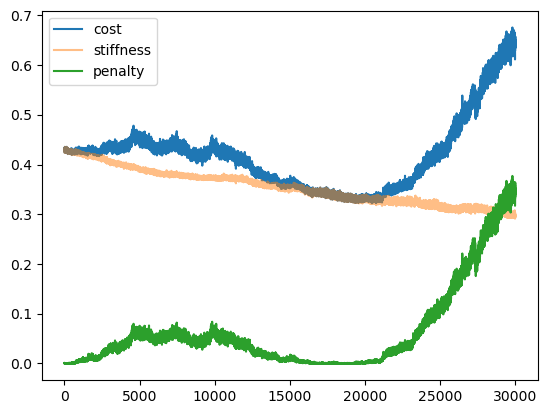

In [24]:
plt.plot(costs)
plt.plot(damages, alpha=0.5)
plt.plot(penalties)
plt.legend(['cost', 'stiffness', 'penalty'])

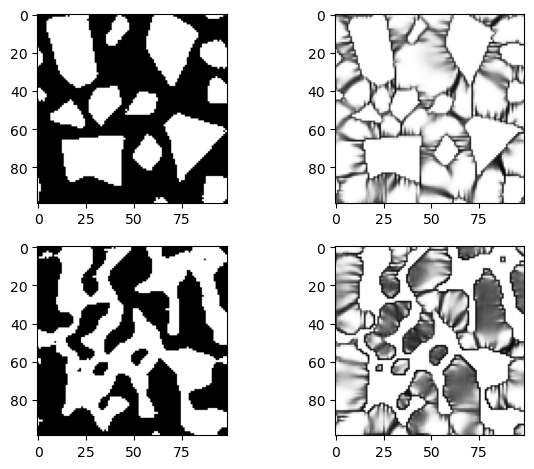

In [25]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(start[0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[0, 1].imshow(start_damage[0,0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 0].imshow(torch.where(new_geometry[0]==1., 1., 0.).detach().cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 1].imshow(y[0,0].detach().cpu(),  cmap='Greys', vmin=0, vmax=1)
plt.tight_layout() 

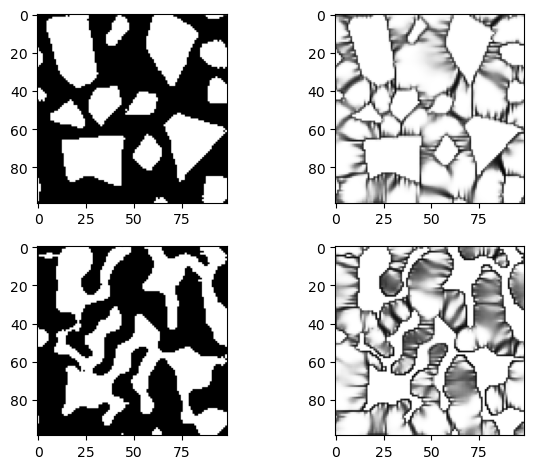

In [22]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(start[0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[0, 1].imshow(start_damage[0,0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 0].imshow(torch.where(new_geometry[0]==1., 1., 0.).detach().cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 1].imshow(y[0,0].detach().cpu(),  cmap='Greys', vmin=0, vmax=1)
plt.tight_layout() 

# Latent space optimization

In [49]:
name_vae = 'NN_library/VAE/VAE'
vae = VariationalAutoencoder(1089)
vae = load_network(vae, name_vae, args)
vae = vae.to(dev)
for p in vae.parameters():
    p.requires_grad_ = False
vae.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (encoder_conv): Sequential(
      (0): CircularPad()
      (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (7): ReLU()
      (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (9): ReLU()
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (12): ReLU()
      (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (14): ReLU()
      (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     

In [50]:
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])

In [59]:
# starting point
geometry_bw = torch.where(geometry==1., 1., 0.)
z = vae.encoder(geometry_bw.view(1,1,99,99)).detach()
z.requires_grad_()
optimizer = optim.Adam([z], lr = 0.001, maximize=False)
geometry_r = vae.decoder(z).view(1,99,99)
start = geometry_r.data
volume = torch.where(geometry_r==1., 1., 0.).sum() / 99**2
costs = []
damages = []
penalties = []

In [ ]:
for i in range(10000):
    new_geometry = vae.decoder(z).view(1,99,99)
    new_geometry = add_interface(new_geometry)
    for n in range(10):
        if n == 0:
            x = torch.cat([new_geometry, imp_shrinkage[[1],:,:] / -0.001, damage[[0],:,:]], axis=0)
        else:
            x = torch.cat([new_geometry, imp_shrinkage[[n+1],:,:] / -0.001, y[0]], axis=0)
        y = unet(x.unsqueeze(0))
    #if i == 0:
        #start_damage = y.data
    cost, d, p = cost_function(y, new_geometry, volume)
    # Optimizer step
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    costs.append(cost.item())
    damages.append(d)
    penalties.append(p)

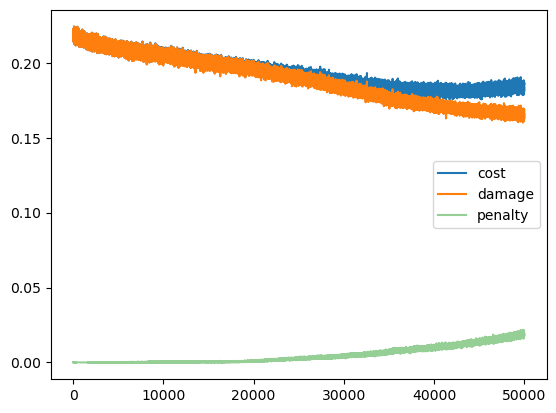

In [78]:
plt.plot(costs)
plt.plot(damages)
plt.plot(penalties, alpha=0.5)
plt.legend(['cost', 'damage', 'penalty'])

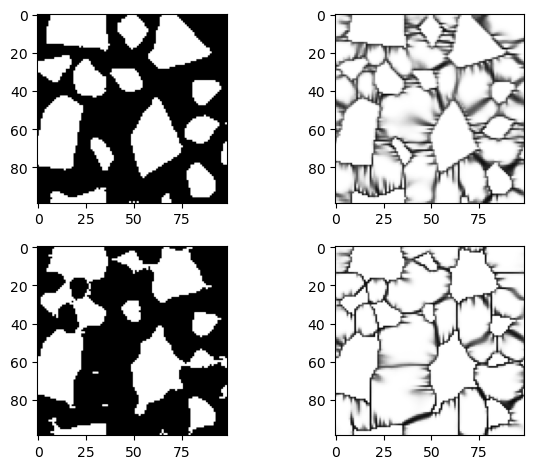

In [75]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(start[0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[0, 1].imshow(start_damage[0,0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 0].imshow(torch.where(new_geometry[0]==1., 1., 0.).detach().cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 1].imshow(y[0,0].detach().cpu(),  cmap='Greys', vmin=0, vmax=1)
plt.tight_layout() 

# Regular grid optimization

In [49]:
name_vae = 'NN_library/VAE/VAE'
vae = VariationalAutoencoder(1089)
vae = load_network(vae, name_vae, args)
vae = vae.to(dev)
for p in vae.parameters():
    p.requires_grad_ = False
vae.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (encoder_conv): Sequential(
      (0): CircularPad()
      (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (7): ReLU()
      (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (9): ReLU()
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (12): ReLU()
      (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
      (14): ReLU()
      (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     

In [50]:
def cost_function_shrinkage(damage, geometry, volume):
    new_volume = torch.where(geometry==1., 1., 0.).sum() / 99**2
    total_shr = damage[:,0].sum()
    penalty = 10 * (new_volume - volume)**2
    cost = total_shr + penalty
    return cost, total_shr.item(), penalty.item()

In [51]:
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])

In [52]:
# starting point
geometry_h = torch.zeros((1, 1, 99, 99))
geometry_w = torch.zeros((1, 1, 99, 99))
for i in range(5):
    geometry_h[:,:,i::10] = 1.
    geometry_w[:,:,:,i::10] = 1.
geometry_bw = (1 - geometry_h * geometry_w).to(dev)
z = vae.encoder(geometry_bw.view(1,1,99,99)).detach()
z.requires_grad_()
optimizer = optim.Adam([z], lr = 0.001, maximize=False)
geometry_r = vae.decoder(z).view(1,99,99)
start = geometry_r.data
volume = torch.where(geometry_r==1., 1., 0.).sum() / 99**2
costs = []
damages = []
penalties = []

In [53]:
for i in range(10000):
    new_geometry = vae.decoder(z).view(1,99,99)
    new_geometry = add_interface(new_geometry)
    for n in range(10):
        if n == 0:
            x = torch.cat([new_geometry, imp_shrinkage[[1],:,:] / -0.001, damage[[0],:,:]], axis=0)
        else:
            x = torch.cat([new_geometry, imp_shrinkage[[n+1],:,:] / -0.001, y[0]], axis=0)
        y = unet(x.unsqueeze(0))
    x_shr = torch.cat([new_geometry, imp_shrinkage[[-1],:,:] / -0.001, y[0]], axis=0)
    shrinkage = convnet(x_shr.unsqueeze(0))
    if i == 0:
        start_damage = y.data
    cost, d, p = cost_function_shrinkage(shrinkage, new_geometry, volume)
    # Optimizer step
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    costs.append(cost.item())
    damages.append(d)
    penalties.append(p)

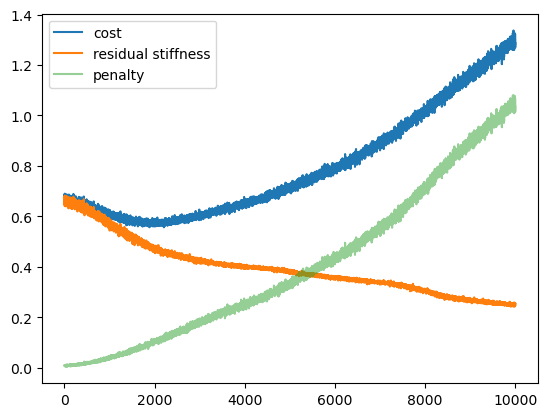

In [56]:
plt.plot(costs)
plt.plot(damages)
plt.plot(penalties, alpha=0.5)
plt.legend(['cost','residual stiffness', 'penalty'])

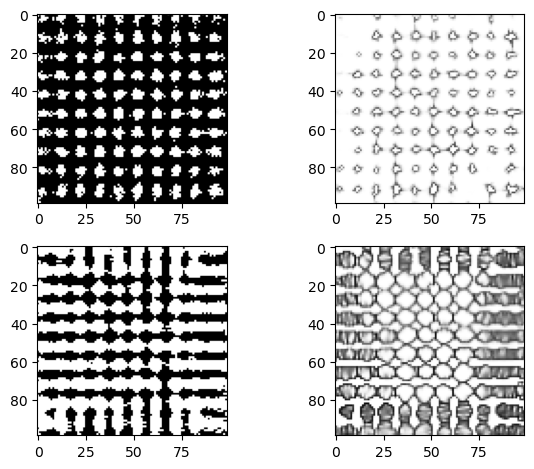

In [55]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(start[0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[0, 1].imshow(start_damage[0,0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 0].imshow(torch.where(new_geometry[0]==1., 1., 0.).detach().cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 1].imshow(y[0,0].detach().cpu(),  cmap='Greys', vmin=0, vmax=1)
plt.tight_layout() 

# Pixel-wise optimization

In [14]:
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])

In [15]:
geometry_bw = torch.where(geometry==1., 1., 0.)
# starting point
geometry_logit = torch.zeros([2, 99, 99], device=dev)
geometry_logit[0] = torch.where(geometry_bw==0., 1e1, -1e1)
geometry_logit[1] = torch.where(geometry_bw==1., 1e1, -1e1)
geometry_logit = pad(geometry_logit.unsqueeze(0), pad=(1, 1, 1, 1), mode = 'circular')
geometry_logit = avg_pool2d(geometry_logit, stride=1, kernel_size=3).squeeze()
geometry_logit.requires_grad_()
optimizer = optim.Adam([geometry_logit], lr = 0.0001, maximize=False)
costs = []
damages = []
penalties = []

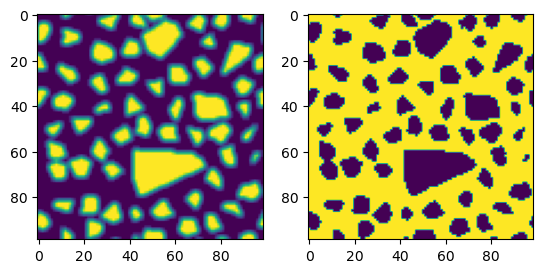

In [16]:
new_geometry = gumbel_softmax(geometry_logit, hard=True, dim=0)[[1],:,:]
start = new_geometry.data
volume = torch.where(new_geometry==1., 1., 0.).sum() / 99**2
fig, axs = plt.subplots(1, 2)
axs[0].imshow(geometry_logit[0].cpu().detach())
axs[1].imshow(new_geometry[0].cpu().detach())

In [51]:
for i in range(10000):
    new_geometry = gumbel_softmax(geometry_logit, hard=True, dim=0)[[1],:,:]
    new_geometry = add_interface(new_geometry)
    acc_damage = torch.zeros([1, 1, 99, 99], device=dev)
    for n in range(10):
        if n == 0:
            x = torch.cat([new_geometry, imp_shrinkage[[1],:,:] / -0.001, damage[[0],:,:]], axis=0)
        else:
            x = torch.cat([new_geometry, imp_shrinkage[[n+1],:,:] / -0.001, y[0]], axis=0)
        y = unet(x.unsqueeze(0))
        acc_damage += y
    if i == 0:
        start_damage = y.data
    cost, d, p = cost_function(acc_damage, new_geometry, volume)
    # Optimizer step
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    costs.append(cost.item())
    damages.append(d)
    penalties.append(p)

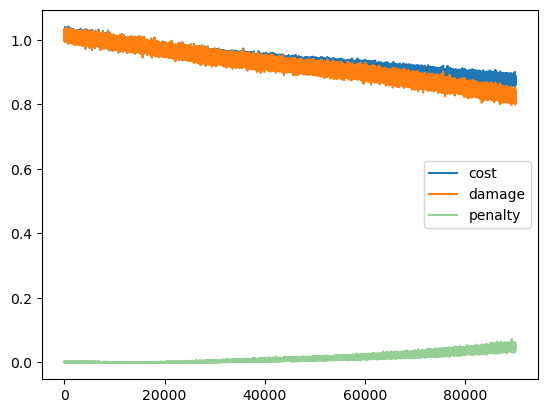

In [53]:
plt.plot(costs)
plt.plot(damages)
plt.plot(penalties, alpha=0.5)
plt.legend(['cost', 'damage', 'penalty'])

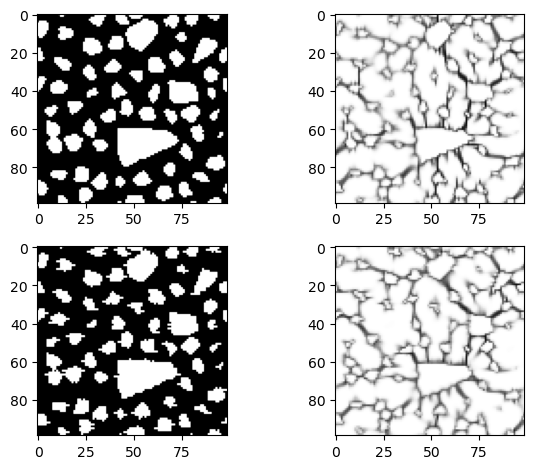

In [54]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(start[0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[0, 1].imshow(start_damage[0,0].cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 0].imshow(torch.where(new_geometry[0]==1., 1., 0.).detach().cpu(), cmap='Greys', vmin=0, vmax=1)
axs[1, 1].imshow(y[0,0].detach().cpu(),  cmap='Greys', vmin=0, vmax=1)
plt.tight_layout() 